<a href="https://colab.research.google.com/github/khushi2810/dogs-vs-cats-cnn-classifier/blob/main/dogsvscats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import required package**

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))

['dogs-vs-cats']


### **Analysing and Preprocessing**
##### Loading the data of all the cat images and dog images to get their size



In [ ]:
filenames = os.listdir("../input/dogs-vs-cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,cat.12461.jpg,0
1,dog.3443.jpg,1
2,dog.7971.jpg,1
3,dog.10728.jpg,1
4,dog.1942.jpg,1


In [ ]:
df.tail()

,filename,category
24995,cat.3664.jpg,0
24996,dog.1783.jpg,1
24997,dog.9392.jpg,1
24998,dog.1631.jpg,1
24999,dog.6938.jpg,1


<AxesSubplot:>

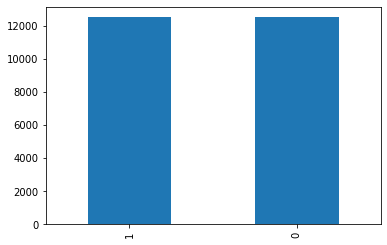

In [ ]:
df['category'].value_counts().plot.bar()

We note that there are 12000 images each of both dogs and cats 

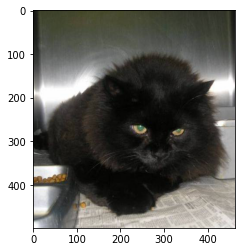

In [ ]:
sample = random.choice(filenames) #loading a sample image
image = load_img("../input/dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

### **Implementation**


In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(128,128,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    #the model so far outputs 3D feature maps (height, width, features)
    tf.keras.layers.Flatten(), #this converts our 3D feature maps to 1D feature vectors
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(2, activation='softmax')
])
#compiling and optimizing
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
earlystop = EarlyStopping(patience= 7)#to stop training once the model performance stops improving on a hold out validation dataset.
tqdm_callback = TqdmCallback(verbose=2)
callbacks = [earlystop, tqdm_callback]

0epoch [00:00, ?epoch/s]

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

##### We split our training data into training set which has 20000 training samples and 5000 validation samples

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

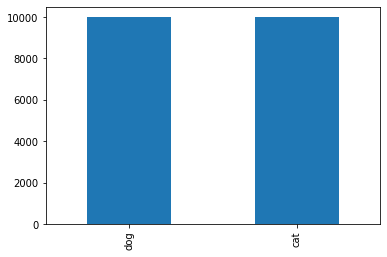

In [ ]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

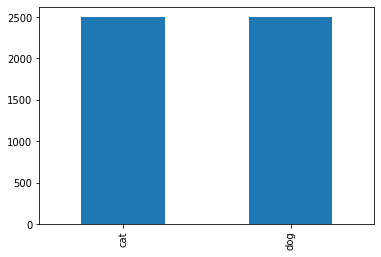

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### **Data Augmentation**
##### We rotate and rescale our training data to get even more training samples so as to reduce overfitting. We then load the data and fit our model.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


##### We test our image generator on a sample image

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


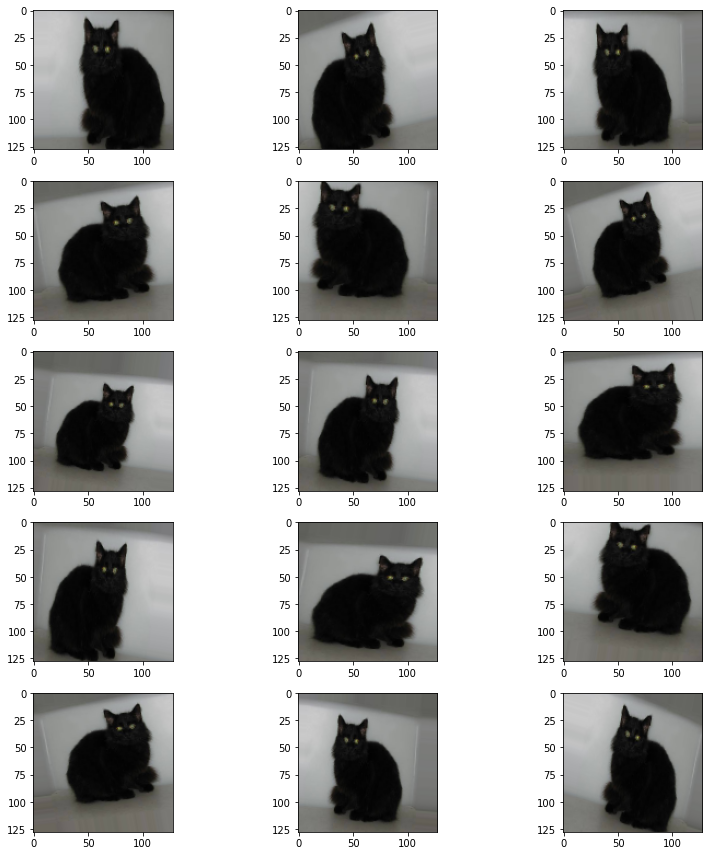

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
#fitting our model
FAST_RUN= False
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 269s 198ms/step - loss: 0.8467 - accuracy: 0.5957 - val_loss: 0.6269 - val_accuracy: 0.6553
Epoch 2/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 151s 113ms/step - loss: 0.6350 - accuracy: 0.6452 - val_loss: 0.6784 - val_accuracy: 0.6799
Epoch 3/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 152s 114ms/step - loss: 0.5776 - accuracy: 0.6963 - val_loss: 0.5762 - val_accuracy: 0.7067
Epoch 4/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 152s 114ms/step - loss: 0.5396 - accuracy: 0.7256 - val_loss: 0.6798 - val_accuracy: 0.6763
Epoch 5/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 152s 114ms/step - loss: 0.5315 - accuracy: 0.7292 - val_loss: 0.4755 - val_accuracy: 0.7812
Epoch 6/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 152s 114ms/step - loss: 0.5022 - accuracy: 0.7507 - val_loss: 0.4757 - val_accuracy: 0.7786
Epoch 7/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 157s 118ms/step - loss: 0.4854 - accuracy: 0.7662 - val_loss: 0.5943 - val_accuracy: 0.7315
Epoch 8/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 158s 118ms/step - loss: 0.5053 - accuracy: 0.7593 - val_loss: 0.4908 - val_accuracy: 0.7764
Epoch 9/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 156s 117ms/step - loss: 0.4627 - accuracy: 0.7829 - val_loss: 0.4254 - val_accuracy: 0.8032
Epoch 10/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 154s 116ms/step - loss: 0.4607 - accuracy: 0.7857 - val_loss: 0.4172 - val_accuracy: 0.8054
Epoch 11/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 155s 116ms/step - loss: 0.4481 - accuracy: 0.7900 - val_loss: 0.4819 - val_accuracy: 0.7972
Epoch 12/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 158s 119ms/step - loss: 0.4355 - accuracy: 0.7990 - val_loss: 0.3932 - val_accuracy: 0.8302
Epoch 13/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 157s 118ms/step - loss: 0.4207 - accuracy: 0.8091 - val_loss: 0.4236 - val_accuracy: 0.8082
Epoch 14/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 155s 116ms/step - loss: 0.4180 - accuracy: 0.8061 - val_loss: 0.4840 - val_accuracy: 0.7662
Epoch 15/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 154s 115ms/step - loss: 0.4335 - accuracy: 0.7949 - val_loss: 0.4308 - val_accuracy: 0.8188
Epoch 16/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 154s 115ms/step - loss: 0.4070 - accuracy: 0.8120 - val_loss: 0.5404 - val_accuracy: 0.7854
Epoch 17/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 155s 116ms/step - loss: 0.4056 - accuracy: 0.8145 - val_loss: 0.3461 - val_accuracy: 0.8436
Epoch 18/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 158s 119ms/step - loss: 0.3783 - accuracy: 0.8291 - val_loss: 0.6842 - val_accuracy: 0.7666
Epoch 19/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 158s 119ms/step - loss: 0.3820 - accuracy: 0.8303 - val_loss: 0.4471 - val_accuracy: 0.8056
Epoch 20/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 156s 117ms/step - loss: 0.4048 - accuracy: 0.8140 - val_loss: 0.4906 - val_accuracy: 0.8010
Epoch 21/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 158s 118ms/step - loss: 0.3783 - accuracy: 0.8279 - val_loss: 0.3115 - val_accuracy: 0.8631
Epoch 22/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 156s 117ms/step - loss: 0.3717 - accuracy: 0.8323 - val_loss: 0.4745 - val_accuracy: 0.7944
Epoch 23/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 156s 117ms/step - loss: 0.3753 - accuracy: 0.8256 - val_loss: 0.4190 - val_accuracy: 0.8338
Epoch 24/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 156s 117ms/step - loss: 0.3777 - accuracy: 0.8326 - val_loss: 0.4865 - val_accuracy: 0.7788
Epoch 25/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3664 - accuracy: 0.8376 - val_loss: 0.3688 - val_accuracy: 0.8406
Epoch 26/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 154s 115ms/step - loss: 0.3469 - accuracy: 0.8456 - val_loss: 1.0494 - val_accuracy: 0.6831
Epoch 27/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 153s 115ms/step - loss: 0.3651 - accuracy: 0.8400 - val_loss: 0.2817 - val_accuracy: 0.8783
Epoch 28/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 152s 114ms/step - loss: 0.3392 - accuracy: 0.8515 - val_loss: 0.2834 - val_accuracy: 0.8767
Epoch 29/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 153s 115ms/step - loss: 0.3450 - accuracy: 0.8460 - val_loss: 0.3163 - val_accuracy: 0.8625
Epoch 30/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 151s 114ms/step - loss: 0.3297 - accuracy: 0.8574 - val_loss: 0.3763 - val_accuracy: 0.8466
Epoch 31/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 153s 115ms/step - loss: 0.3271 - accuracy: 0.8533 - val_loss: 0.3426 - val_accuracy: 0.8559
Epoch 32/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 153s 114ms/step - loss: 0.3336 - accuracy: 0.8546 - val_loss: 0.3172 - val_accuracy: 0.8697
Epoch 33/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 154s 115ms/step - loss: 0.3266 - accuracy: 0.8550 - val_loss: 0.4491 - val_accuracy: 0.8166
Epoch 34/50


  0%|          | 0.00/1.33k [00:00<?, ?batch/s]

1333/1333 [==============================] - 156s 117ms/step - loss: 0.3224 - accuracy: 0.8606 - val_loss: 0.4054 - val_accuracy: 0.8368


In [ ]:
model.save_weights("model.h5")

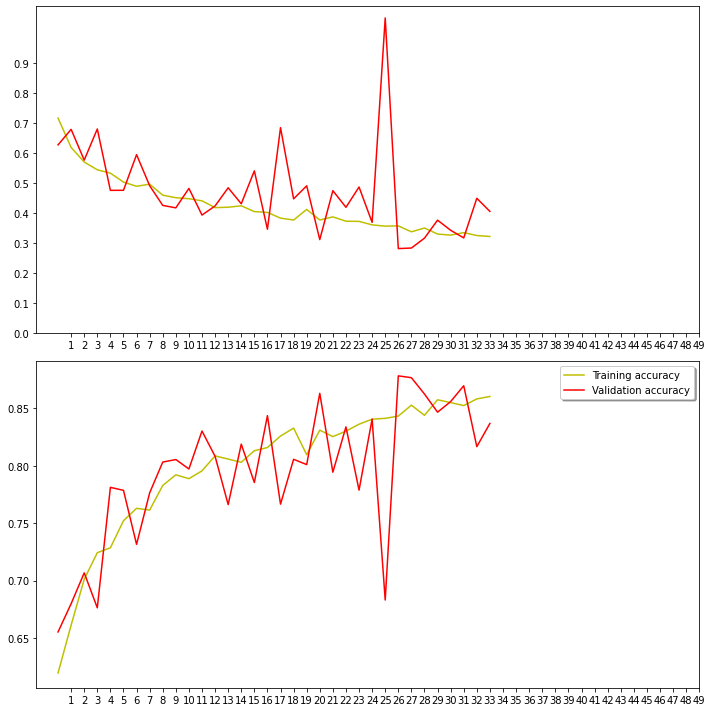

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.plot(history.history['loss'], color='y', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='y', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### **Testing**

In [ ]:
test_filenames = os.listdir("../input/dogs-vs-cats/test/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/dogs-vs-cats/test/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


### **Predicting our model on test images**

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<AxesSubplot:>

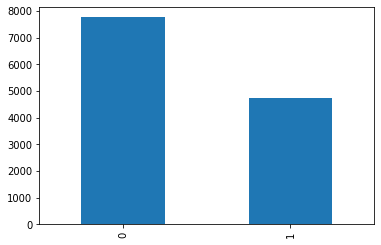

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'].value_counts().plot.bar()

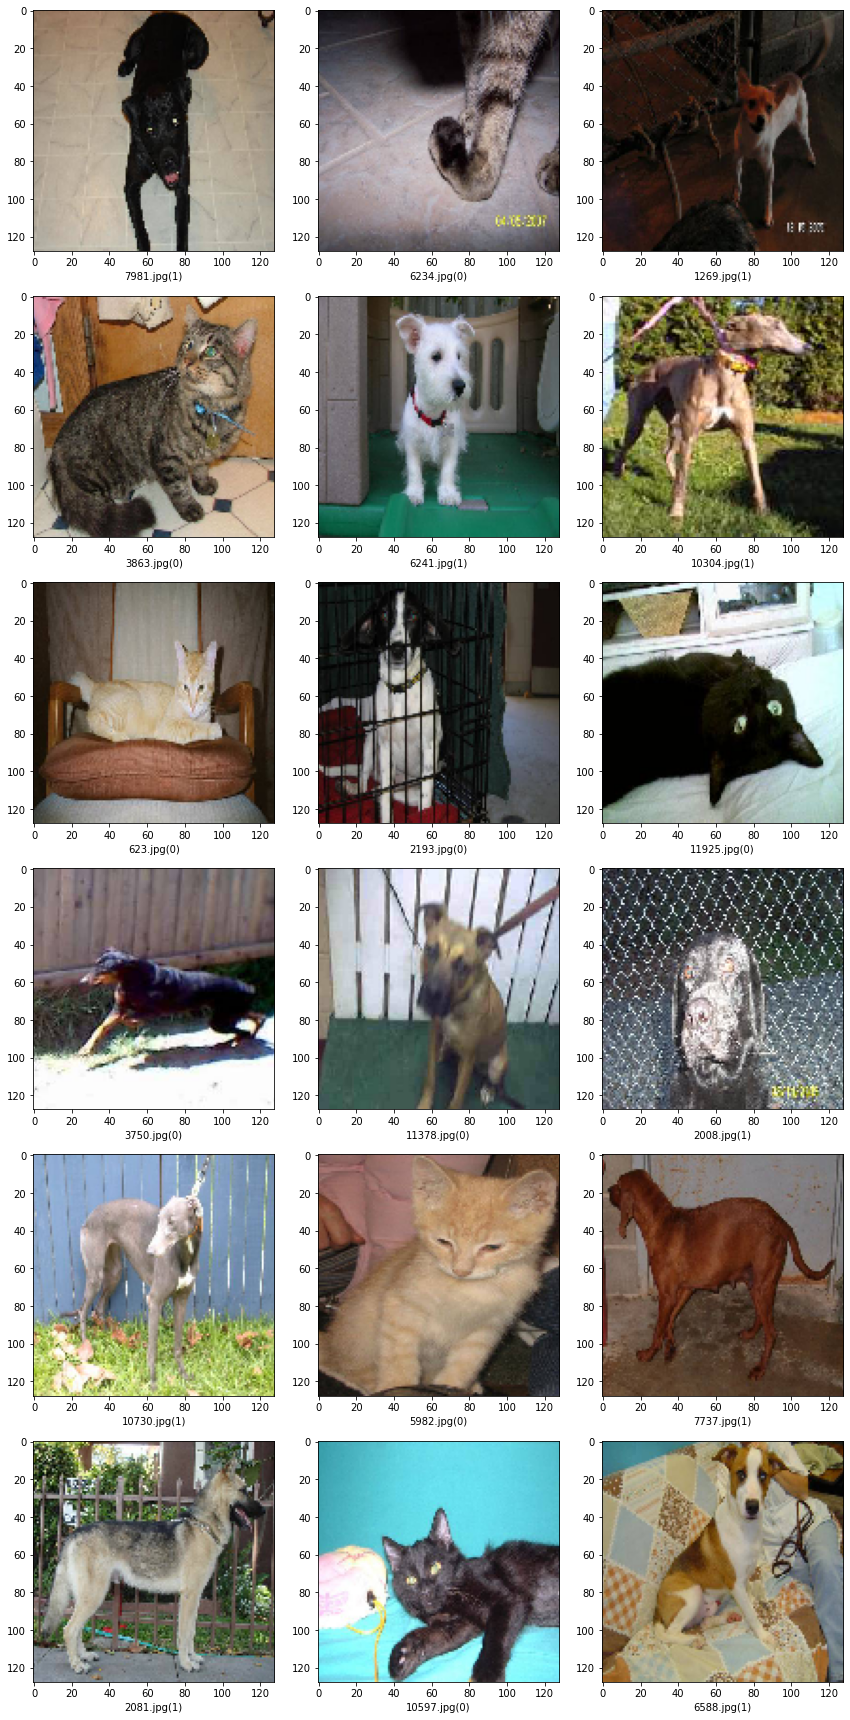

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/dogs-vs-cats/test/test/"+filename, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()